In [3]:
import pandas as pd
import os
import kagglehub

# Kaggle Dataset
path = kagglehub.dataset_download("dinocojagadeeshr/analytics-for-hospitals-healthcare-data")

print("Path to dataset files:", path)

# Checking the contents of the directory to find the correct file name
print("Contents of the directory:", os.listdir(path))

file_path = os.path.join(path, "Hospital_data.csv")  

# Loading the data
hospital_data = pd.read_csv(file_path)

# Displaying the first few rows of the dataset 
print(hospital_data.head())

Path to dataset files: /Users/sandrathermildor/.cache/kagglehub/datasets/dinocojagadeeshr/analytics-for-hospitals-healthcare-data/versions/1
Contents of the directory: ['Hospital_Data.csv']
   case_id  Hospital_code Hospital_type_code  City_Code_Hospital  \
0        1              8                  c                   3   
1        2              2                  c                   5   
2        3             10                  e                   1   
3        4             26                  b                   2   
4        5             26                  b                   2   

  Hospital_region_code  Available Extra Rooms in Hospital    Department  \
0                    Z                                  3  radiotherapy   
1                    Z                                  2  radiotherapy   
2                    X                                  2    anesthesia   
3                    Y                                  2  radiotherapy   
4                    Y    

In [4]:
# Checking for missing values
missing_values = hospital_data.isnull().sum()

# Drop[ing rows with missing values
hospital_data = hospital_data.dropna()

# Converting the 'Stay' column to numerical categories to allow for analysis
stay_mapping = {
    '0-10': 5, '11-20': 15, '21-30': 25, '31-40': 35, '41-50': 45,
    '51-60': 55, '61-70': 65, '71-80': 75, '81-90': 85, '91-100': 95,
    'More than 100 Days': 110
}
hospital_data['Stay_Duration'] = hospital_data['Stay'].map(stay_mapping)

# Previewing the cleaned data
hospital_data.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,Stay_Duration
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911,0-10,5.0
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954,41-50,45.0
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745,31-40,35.0
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272,41-50,45.0
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558,41-50,45.0


In [5]:
# Average Length of Stay by Department
avg_stay_by_department = hospital_data.groupby('Department')['Stay_Duration'].mean()

# Average Deposit by Admission Type
avg_deposit_by_admission = hospital_data.groupby('Type of Admission')['Admission_Deposit'].mean()

# Average Deposit by Severity of Illness
avg_deposit_by_severity = hospital_data.groupby('Severity of Illness')['Admission_Deposit'].mean()

# Displaying KPI tables
print("Average Stay by Department:\n", avg_stay_by_department)
print("\nAverage Deposit by Admission Type:\n", avg_deposit_by_admission)
print("\nAverage Deposit by Severity of Illness:\n", avg_deposit_by_severity)

Average Stay by Department:
 Department
TB & Chest disease    36.168612
anesthesia            36.493149
gynecology            37.586882
radiotherapy          39.242902
surgery               44.035874
Name: Stay_Duration, dtype: float64

Average Deposit by Admission Type:
 Type of Admission
Emergency    4769.484104
Trauma       4987.724110
Urgent       4821.220960
Name: Admission_Deposit, dtype: float64

Average Deposit by Severity of Illness:
 Severity of Illness
Extreme     4748.493479
Minor       4984.758311
Moderate    4874.993542
Name: Admission_Deposit, dtype: float64


In [7]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Converting categorical variables into dummy/indicator variables
hospital_data_encoded = pd.get_dummies(hospital_data[['Type of Admission', 'Severity of Illness']], drop_first=True)

# Combining encoded features with numerical columns
features = pd.concat([hospital_data_encoded, hospital_data[['Stay_Duration']]], axis=1)
target = hospital_data['Admission_Deposit']

# Handling missing values by using SimpleImputer
imputer = SimpleImputer(strategy='median')
features_imputed = imputer.fit_transform(features)

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_imputed, target, test_size=0.3, random_state=42)

# Training a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and model evaluation
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 1163586.5656584054


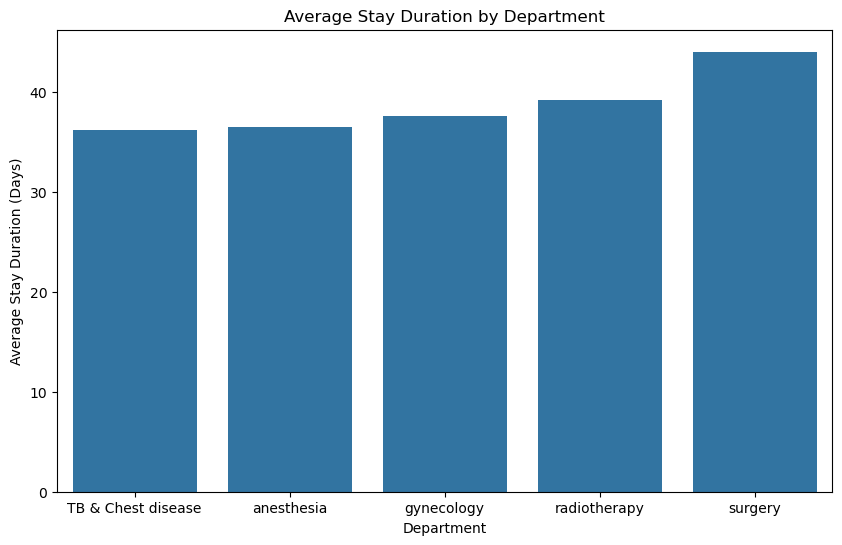

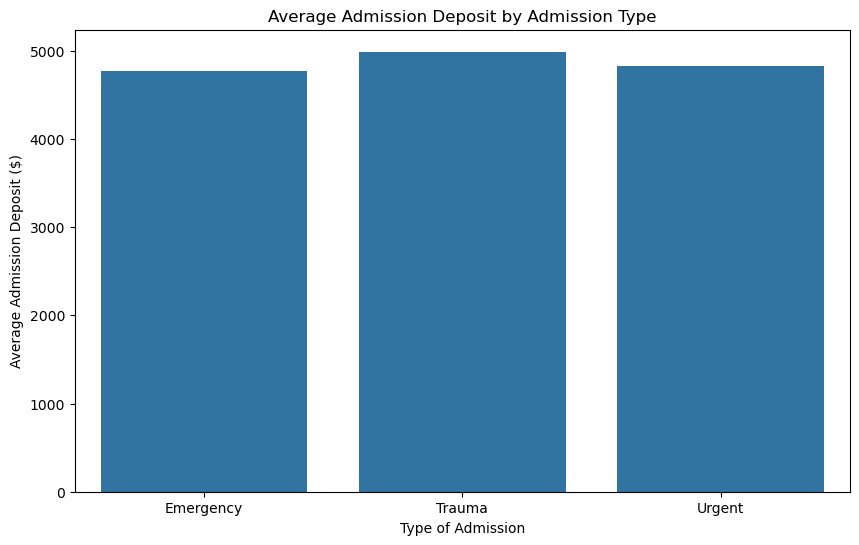

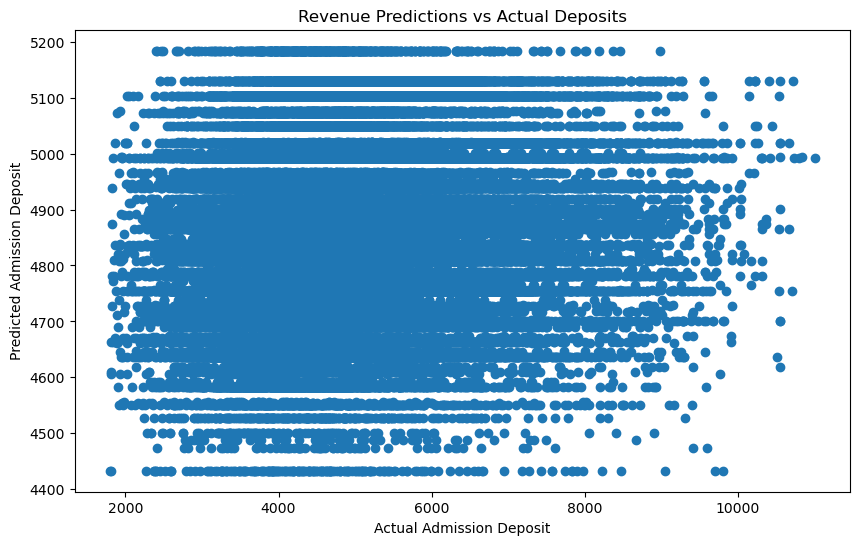

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting Average Stay by Department
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_stay_by_department.index, y=avg_stay_by_department.values)
plt.title('Average Stay Duration by Department')
plt.xlabel('Department')
plt.ylabel('Average Stay Duration (Days)')
plt.show()

# Plotting Average Deposit by Admission Type
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_deposit_by_admission.index, y=avg_deposit_by_admission.values)
plt.title('Average Admission Deposit by Admission Type')
plt.xlabel('Type of Admission')
plt.ylabel('Average Admission Deposit ($)')
plt.show()

# Revenue Prediction Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions)
plt.title('Revenue Predictions vs Actual Deposits')
plt.xlabel('Actual Admission Deposit')
plt.ylabel('Predicted Admission Deposit')
plt.show()